# Analyze temporal patterns of vocal activity
### CNN detections over entire season

In this notebook, we take the results of automated detection using our CNN on the field data, and investigate seasonal and daily activity patterns. 


This notebook is part of a series of notebooks and scripts in the [repository](https://github.com/kitzeslab/rana-sierrae-cnn):

- `01_explore_annotated_data.ipynb` Explore annotated dataset of Rana sierrae call types

- `02_prep_training_data.ipynb` Prepare annotated files for training a CNN machine learning model

- `03_train_cnn.ipynb` Train a CNN to recognize Rana sierrae vocaliztaions

- `04_cnn_prediction.ipynb` Use the cnn to detect Rana sierrae in audio recordings

- `05_cnn_validation.ipynb` Analyze the accuracy and performance of the CNN

- `06_aggregate_scores.py` Aggregate scores from CNN prediction across dates and times of day

- `07_explore_results.ipynb` Analyze temporal patterns of vocal activity using the CNN detections


### Imports

In [1]:
import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path
from datetime import datetime

import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for big visuals
%config InlineBackend.figure_format = 'retina'

### plotting settings

In [2]:
from matplotlib import pyplot as plt
small_txt = 7
med_txt = 8
big_txt = 8
# set text sizes
plt.rcParams['font.size'] = small_txt
plt.rcParams['axes.labelsize'] = med_txt
plt.rcParams['axes.titlesize'] = big_txt
plt.rcParams['xtick.labelsize'] = small_txt
plt.rcParams['ytick.labelsize'] = small_txt
plt.rcParams['legend.fontsize'] = med_txt
plt.rcParams['figure.titlesize'] = big_txt
# opaque legend (<1 is not fully opaque)
plt.rcParams["legend.framealpha"] = 1.0
# set figure size
plt.rcParams['figure.figsize']=[6,2.5]
plt.rcParams['figure.dpi'] = 300
# set default font
# plt.rcParams['font.sans-serif'] = "Gill Sans"
# plt.rcParams['font.family'] = "sans-serif"
# plt.rcParams['font.sans-serif'] = "gillsans"

# TIP use these 2 lines to list all available fonts:
# from matplotlib import font_manager
# font_manager.findSystemFonts(fontpaths=None, fontext="ttf")

# to add a font
# on linux, add .ttf font files to /usr/share/fonts/truetype/
# then follow these instructions https://scentellegher.github.io/visualization/2018/05/02/custom-fonts-matplotlib.html 

# tell matplotlib to create vector fonts (so you can edit them later, eg in Illustrator)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

#color and line style cycles #
# TIP: use https://coolers.co to create nice color palettes
#or modify this one https://coolors.co/35aad8-f3b61f-ba3b54-45b69c-8a96d7
from cycler import cycler
default_cycler = (cycler(color=['#35aad8','#f3b61f','#8a96d7','#45b69c','#ba3b54']) +
                  cycler(linestyle=['-', '--', '-.', ':','-']))

# plt.rc('lines', linewidth=0.5)
plt.rc('axes', prop_cycle=default_cycler)

#use appropriate resolution for retina screens
%config InlineBackend.figure_format='retina'


# Other useful plot manipulations:
# ax = plt.gca() #get axis from current plot

#reformat x ticks to date or time (values should be datetime.datetime)
# ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%d'))

# reduce the number of ticks/labels on an axis
# ax.xaxis.set_major_locator(plt.MaxNLocator(8))

# Analyze seasonal patterns

load total number of detections per threshold

In [3]:
total_detections = pd.read_csv('./resources/total_detections_per_threshold.csv').set_index('threshold')

load and format detections per date

In [4]:
date_total = pd.read_csv('./resources/detections_by_date.csv')
date_total['date']=[datetime.strptime(d,'%Y-%m-%d').date() for d in date_total['date']]
date_total=date_total.set_index('date')
dates = date_total.index
threshold_columns=date_total.columns

scores_card_date = pd.read_csv('./resources/dvar_by_card_and_date.csv')
cards = scores_card_date['card'].unique()
scores_card_date['date']=[datetime.strptime(d,'%Y-%m-%d').date() for d in scores_card_date['date']]
scores_card_date=scores_card_date.set_index(['card','date'])

## Seasonal activity patterns normalized by total number of detections across season

In this plot we normalize the seasonal pattern of activity by the total number of detections at each threshold. This allows us to see whether, despite detecting different numbers of calls, different thresholds actually result in the same observed temporal patterns. We see in the graph below that regardless of threshold, the observed seasonal activity pattern remains very similar. 

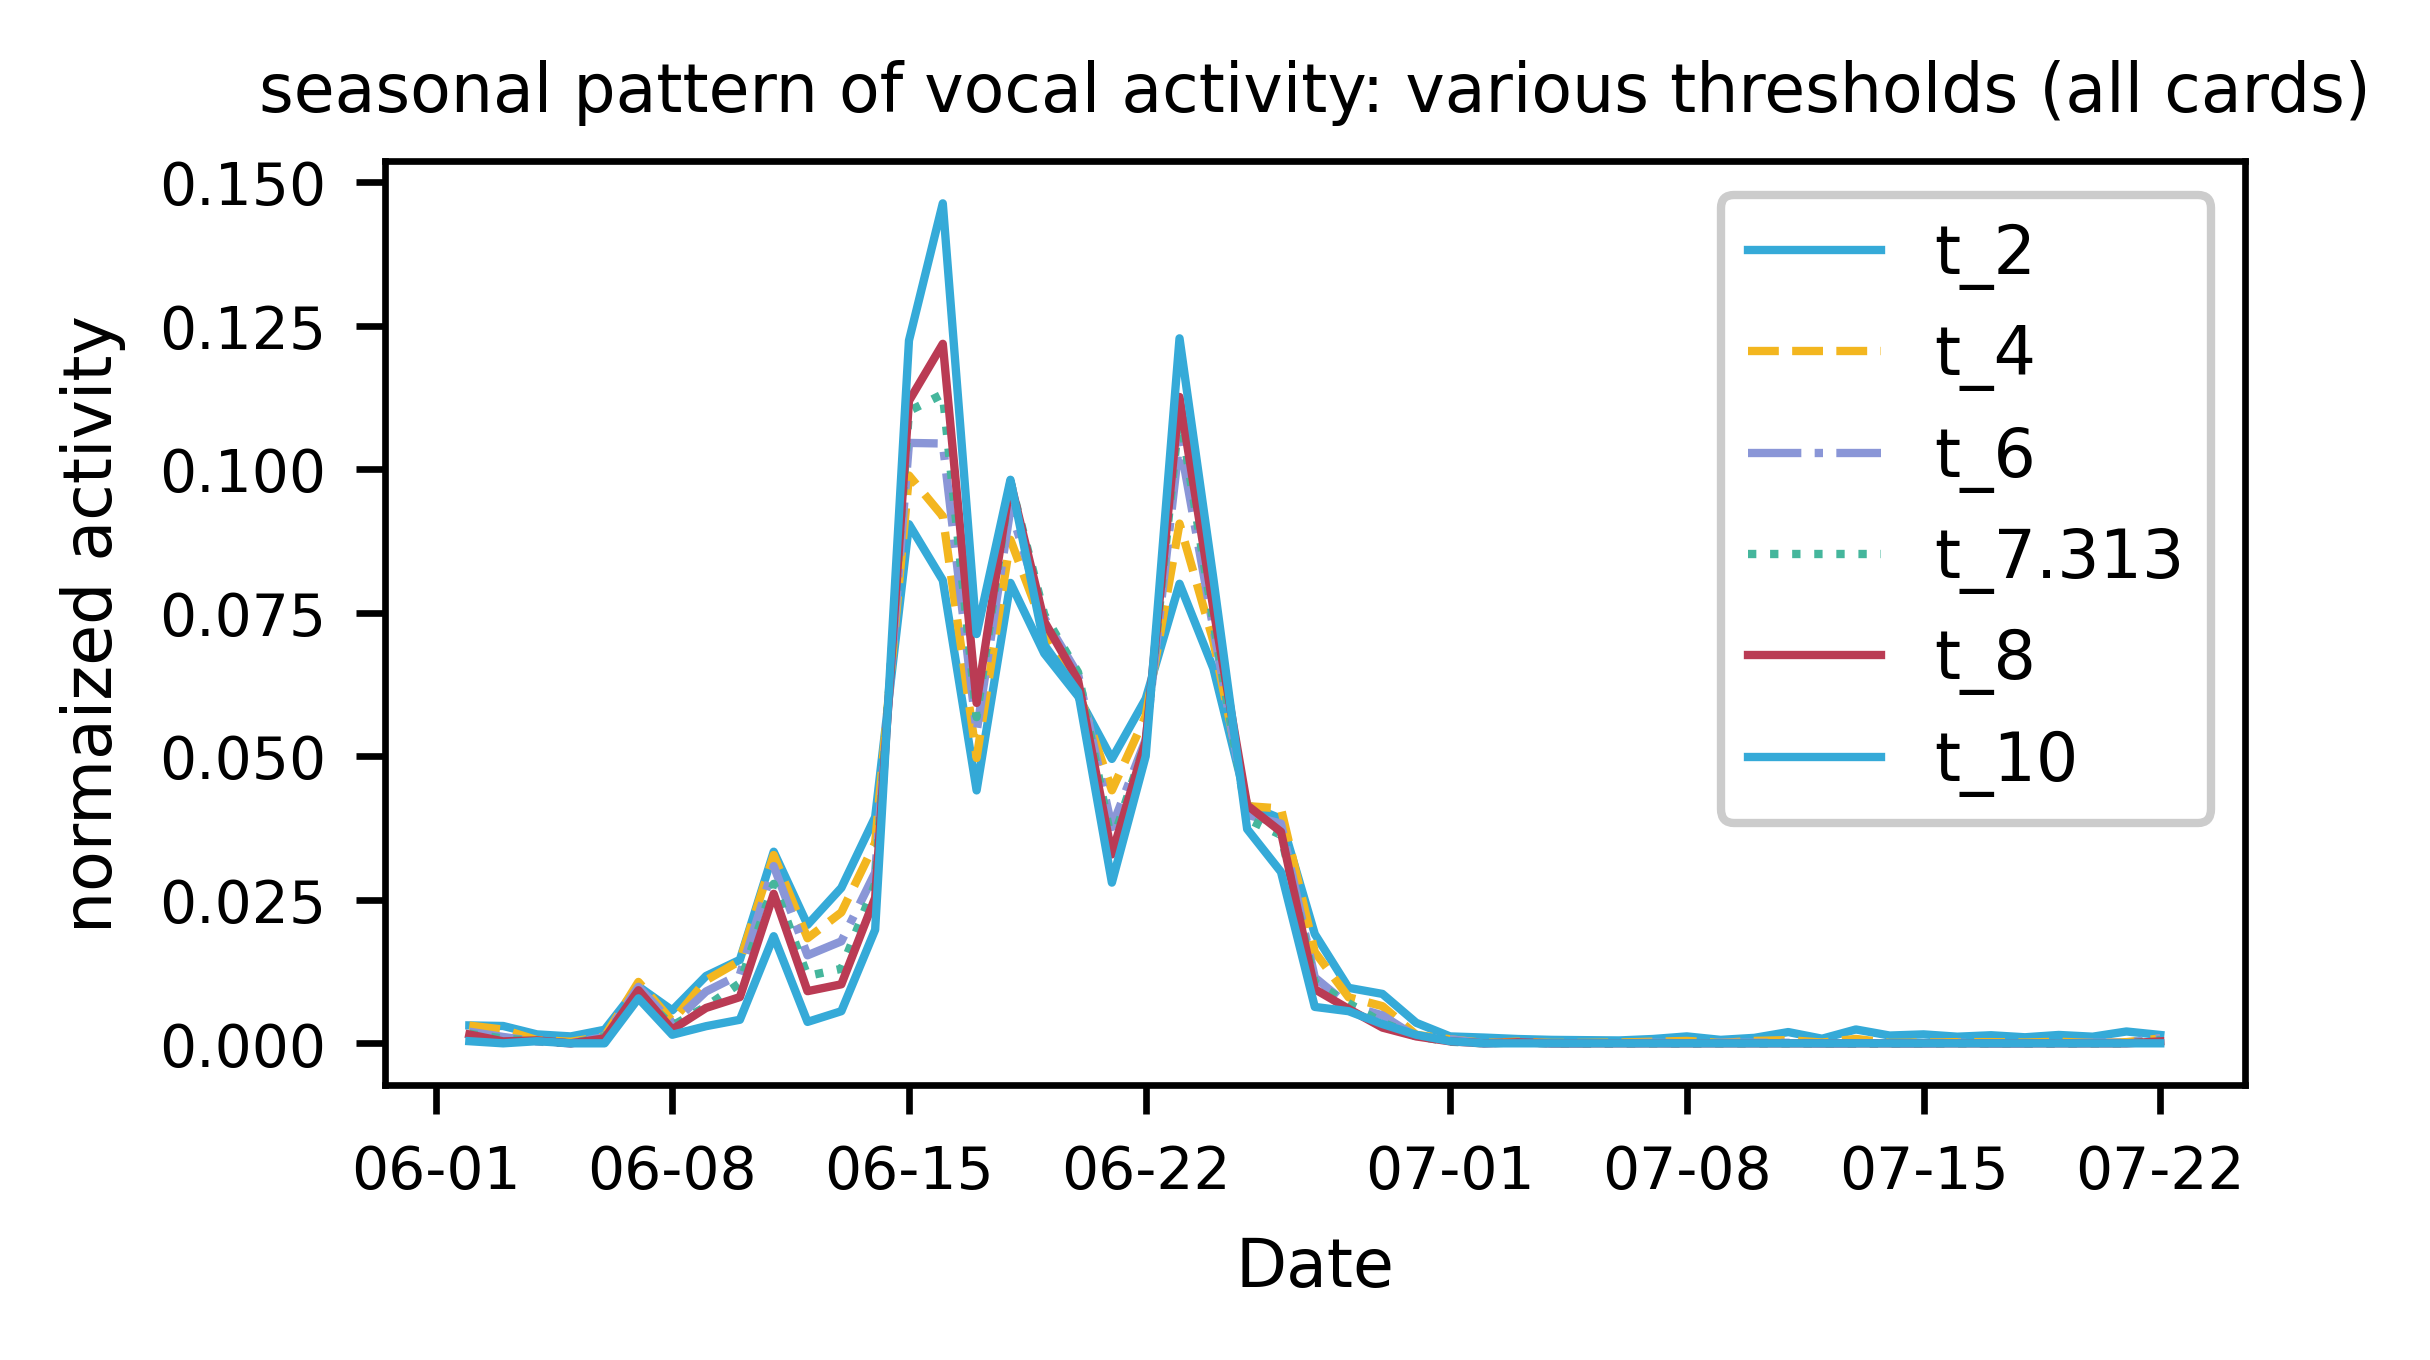

In [5]:
plt.figure(figsize=(4,2)) 
for col in threshold_columns:
    norm = date_total[col]/total_detections.at[col,'count']
    plt.plot(dates,norm,label=col,linewidth=1)
plt.legend()
plt.ylabel('normaized activity')
plt.title('seasonal pattern of vocal activity: various thresholds (all cards)')
plt.xlabel('Date')

#reformat x ticks to date
ax = plt.gca()
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%d'))

#save figure to disk
plt.savefig('./figures/seasonal_activity_normalized_thresholds.pdf')

### Seasonal activity patterns at each device
Here' we'll plot each SD card (one card from each recording device) separately to examine patterns of vocal activity at five locations on the lake. 

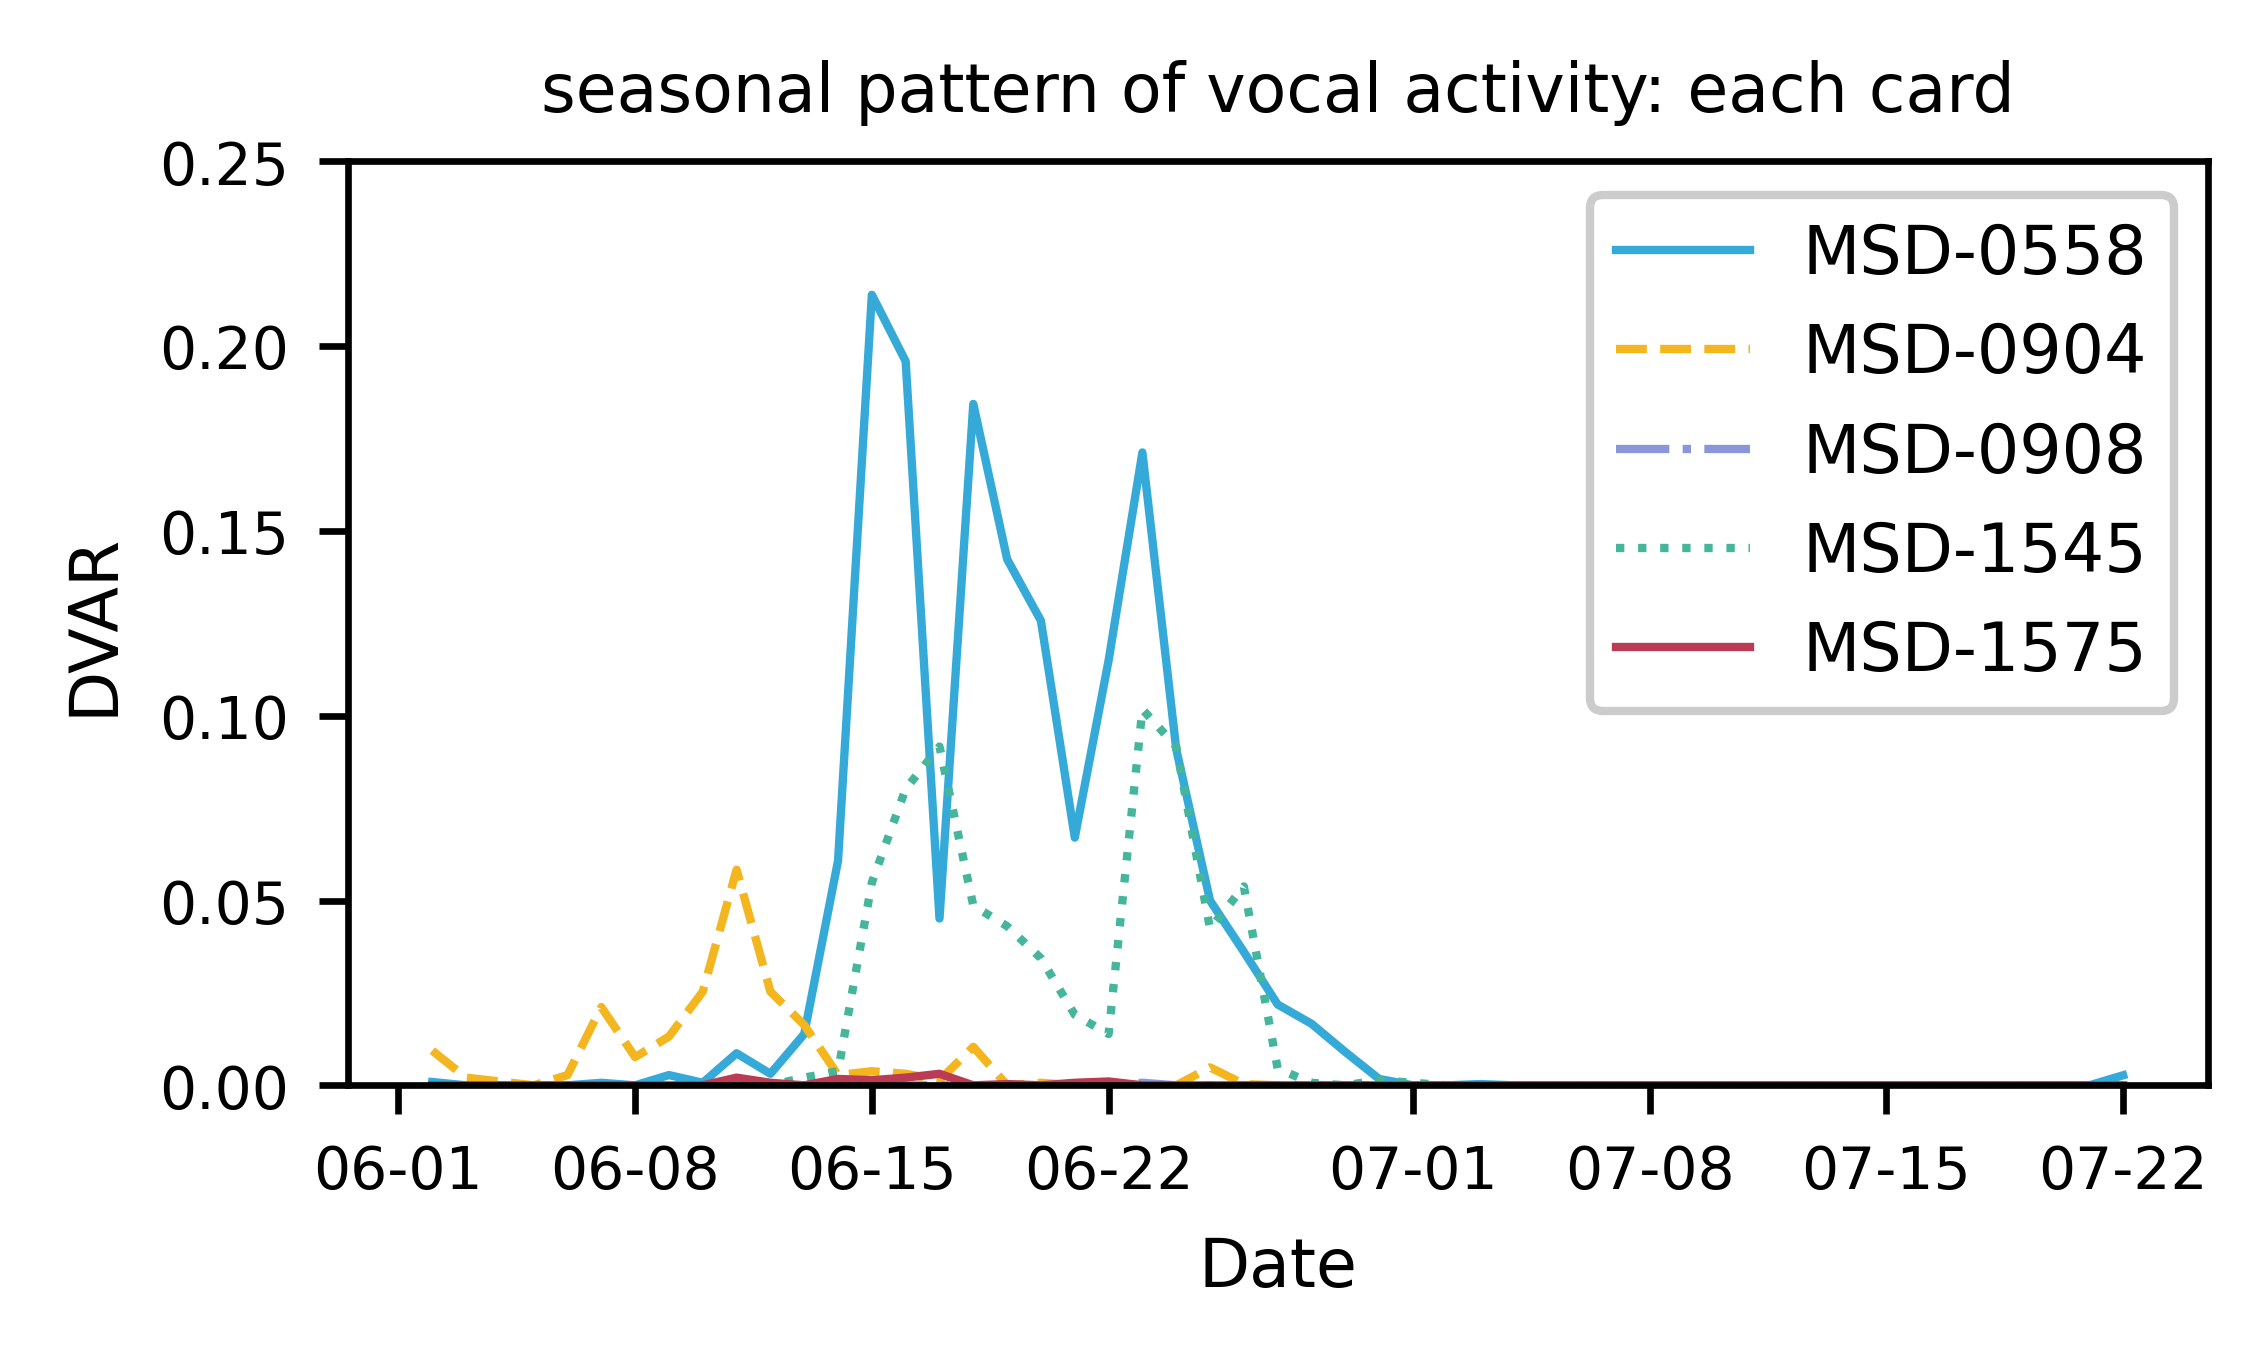

In [6]:
plt.figure(figsize=(4,2)) 

import warnings
warnings.filterwarnings('ignore')
for card in cards:
    dvar = scores_card_date.loc[card]
    # date_total = scores_card.groupby('date').mean()
    col = ['t_7.313'] #just the threshold for 99% precision
    # norm = date_total[col]#/scores_card[col].sum()
    plt.plot(dates,dvar[col],label=card,linewidth=1)
    plt.legend()
    plt.title('seasonal pattern of vocal activity: each card')
plt.ylabel('DVAR')
plt.xlabel('Date')

plt.ylim([0,.25])

#reformat x ticks to date
ax = plt.gca()
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%d'))
plt.savefig('./figures/dvar_by_card.pdf')


# Daily Patterns

Let's examine daily patterns of detected vocal activity rate (DVAR) by summarizing scores across all dates by time of day. 

load and format table of detections per time of day

In [7]:
time_total = pd.read_csv('./resources/detections_by_time.csv')
time_total['time']=[datetime.strptime(d,'%H:%M:%S').time() for d in time_total['time']]
time_total = time_total.set_index('time')
times=time_total.index

In [8]:
time_mean = pd.read_csv('./resources/dvar_by_time.csv')
time_mean['time']=[datetime.strptime(d,'%H:%M:%S').time() for d in time_mean['time']]
time_mean = time_mean.set_index('time')
assert np.all(time_total.index==time_mean.index)

First, we'll test the sensitivity to threshold: We draw detections versus time of day for several thresholds, normalizing the number of detections by the total number of detections at the given threshold. In the graph below, we can see that the observed daily patterns are robust to choice of threshold. 

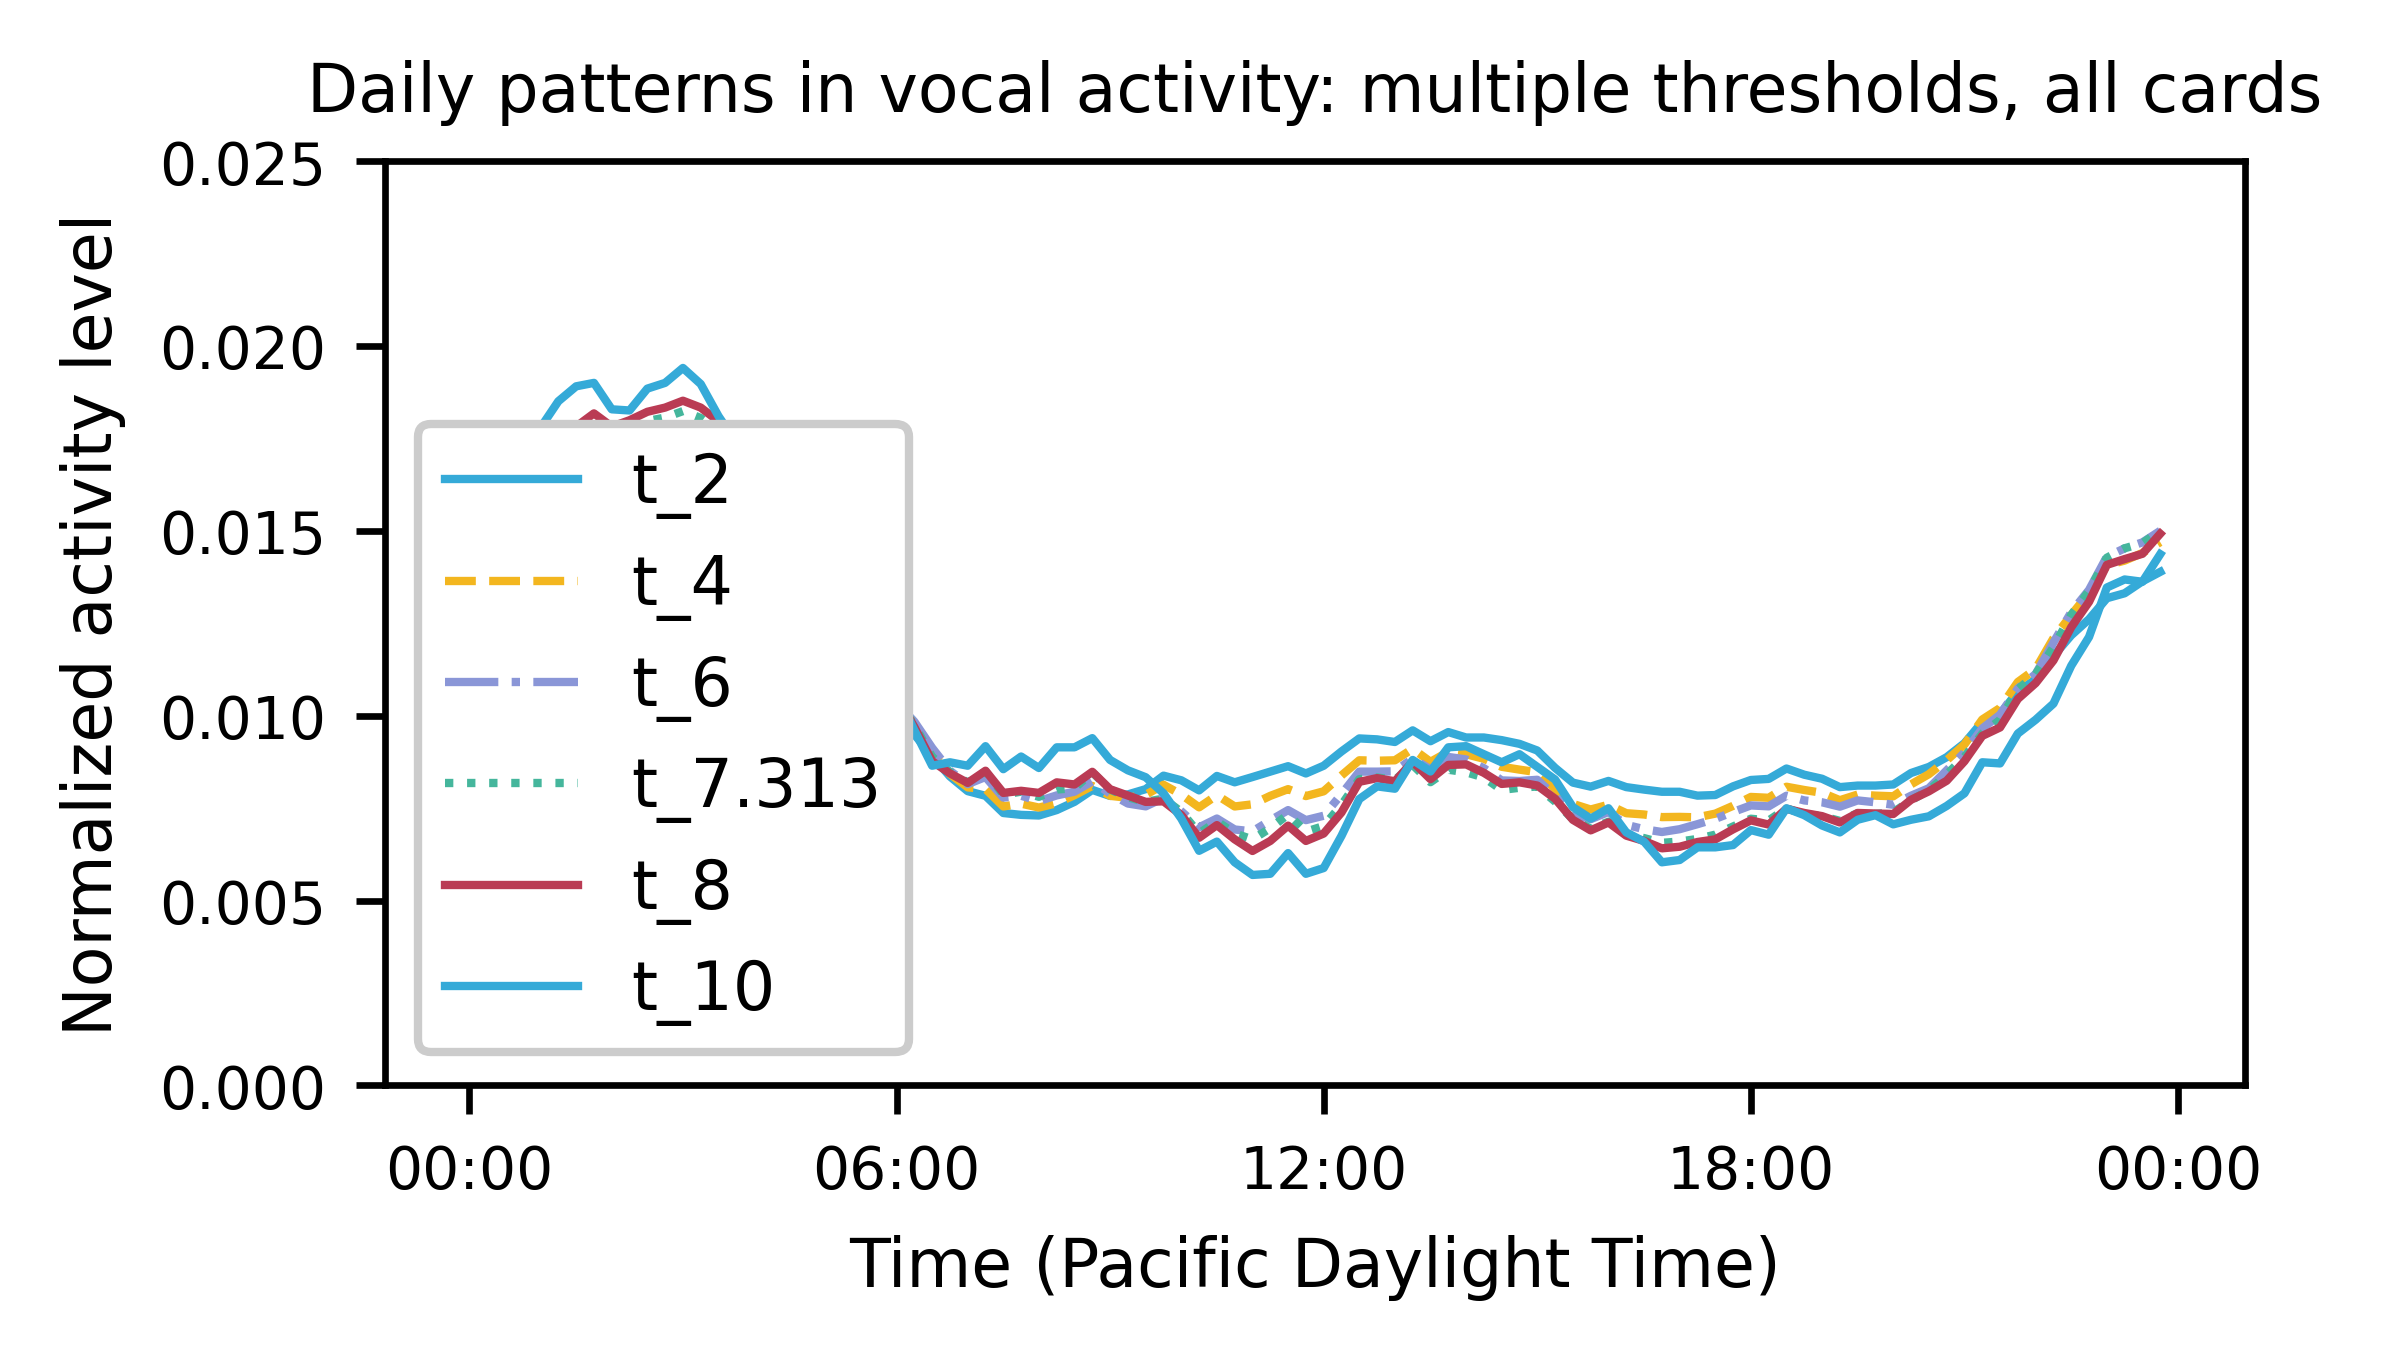

In [9]:
from datetime import datetime
plt.figure(figsize=(4,2)) 

rolling_avg_size = 12
time_total_rolling = time_total.tail(rolling_avg_size-1).append(time_total) #wrap arround for moving avg
dt = [datetime.combine(datetime.today(),t) for t in time_total_rolling.index]

for col in threshold_columns:
    
    norm = time_total_rolling[col].rolling(rolling_avg_size).mean()/total_detections.at[col,'count']
    plt.plot(dt,norm,label=col,linewidth=1)

plt.title('Daily patterns in vocal activity: multiple thresholds, all cards')

# PLOTTING SETTINGS
ax = plt.gca()
#reformat x ticks to time
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
# use less axis labels
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.legend()
ax.set_xlabel('Time (Pacific Daylight Time)')
ax.set_ylabel('Normalized activity level')
ax.set_ylim(0,0.025)

plt.savefig('./figures/time_with_3hr_rolling_avg_thresholds.pdf')

Now, let's simply plot the detected vocal activity rate (DVAR) across the day. Here, DVAR is the proportion of clips at a given time of day that contain a detection. 

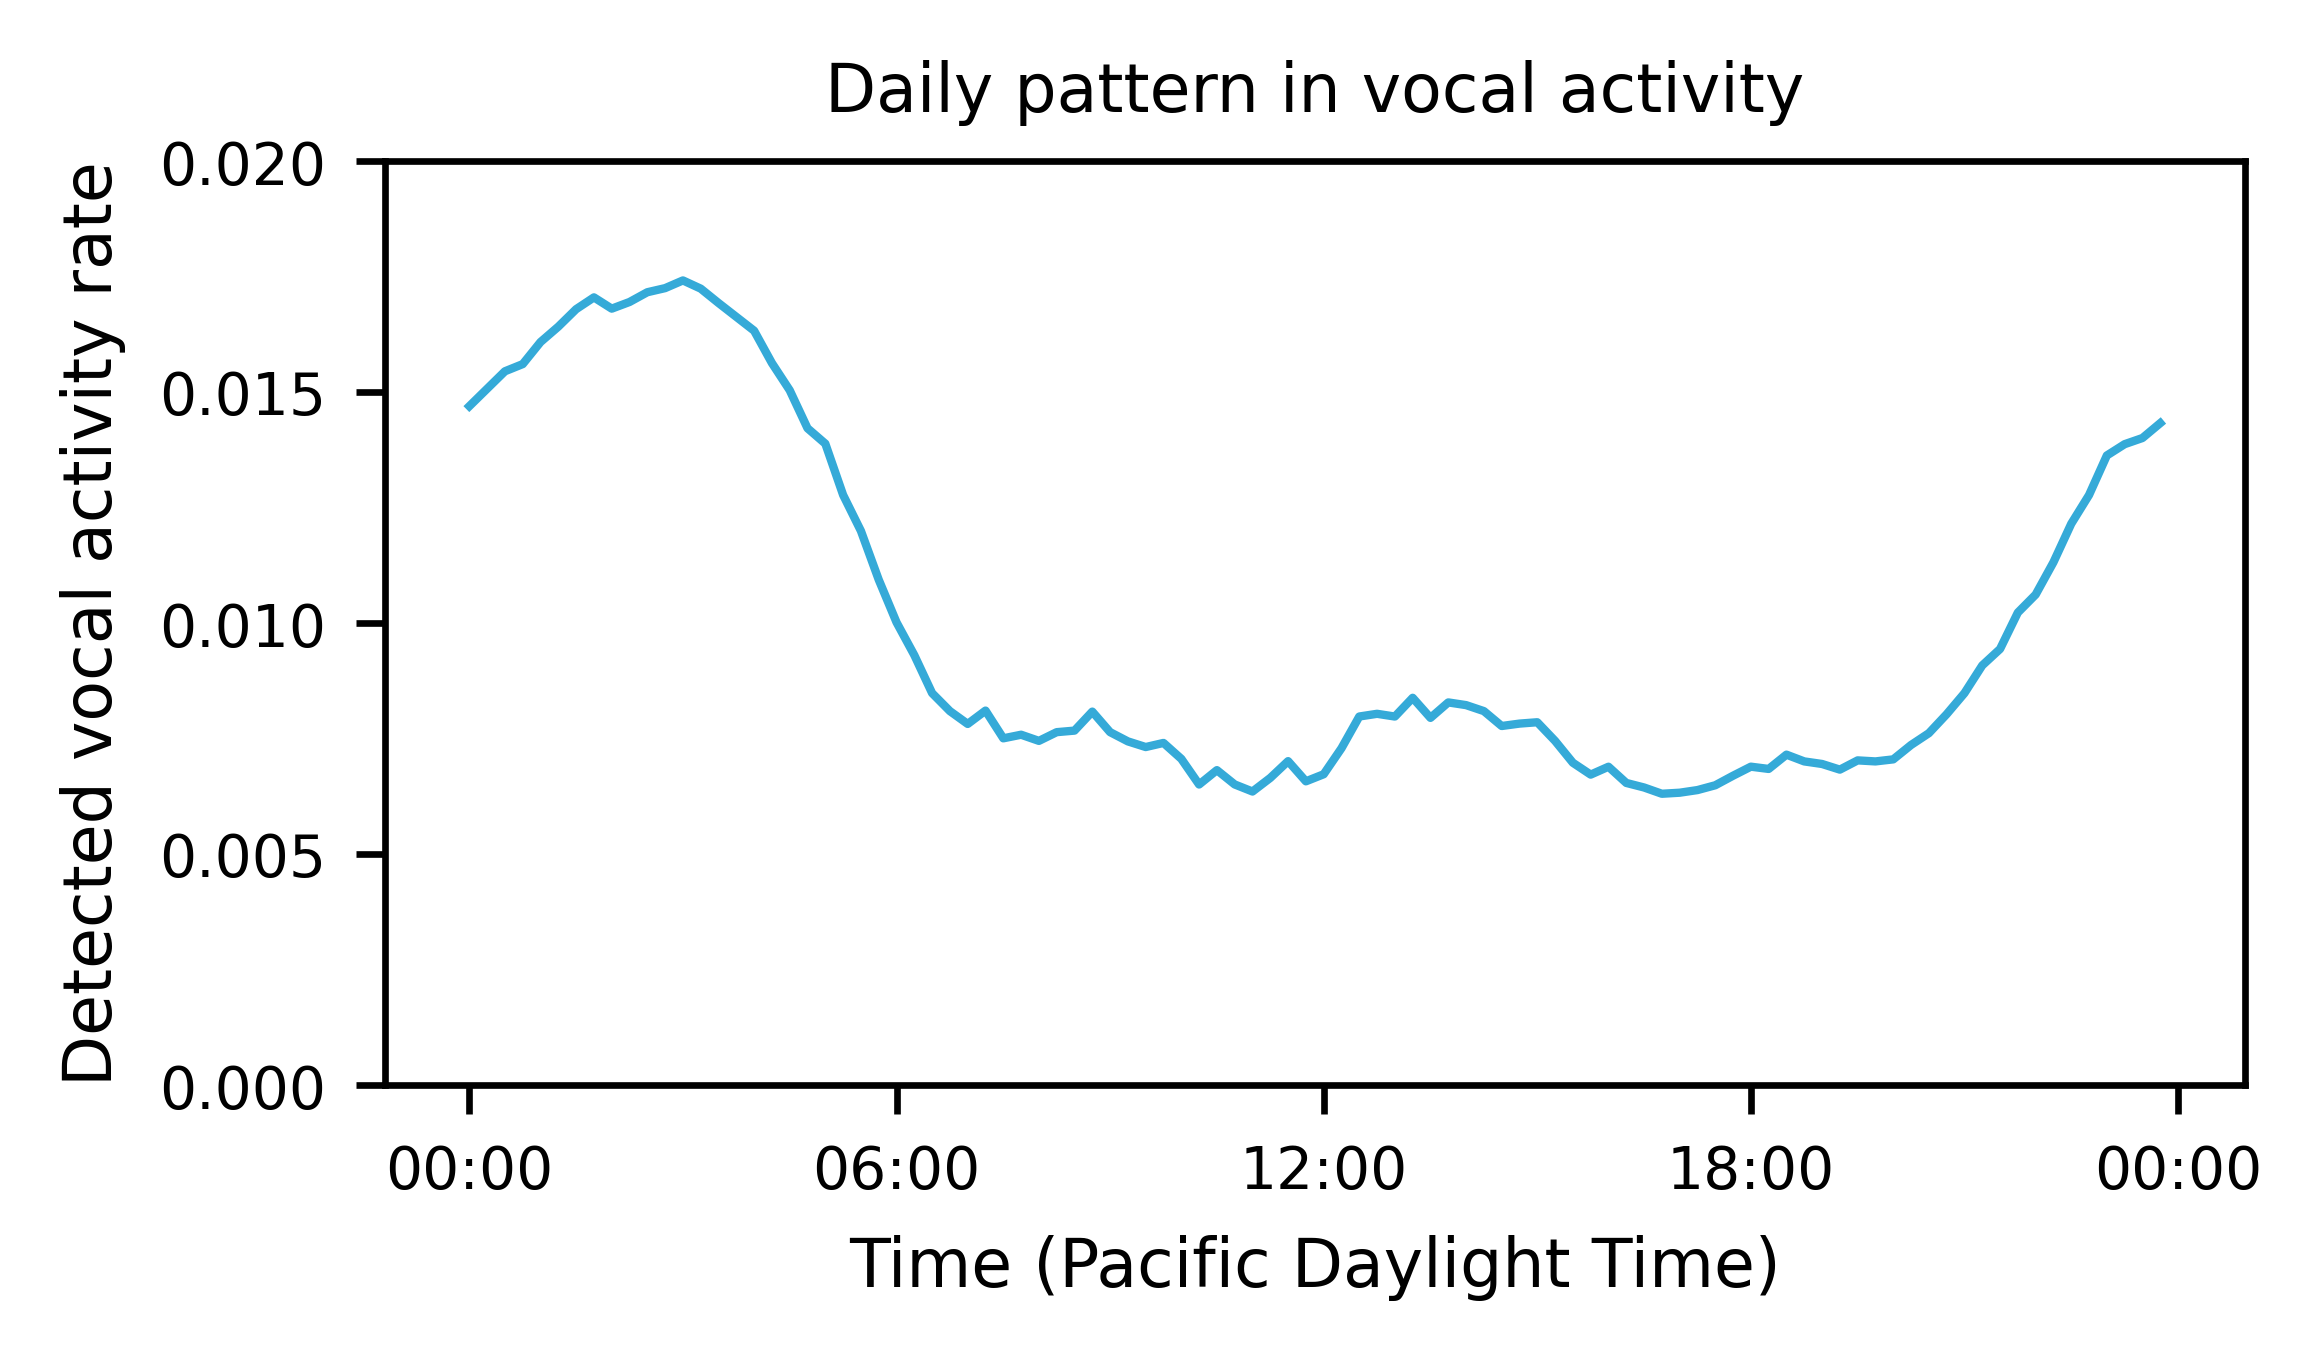

In [10]:
from datetime import datetime
plt.figure(figsize=(4,2)) 

rolling_avg_size = 12

time_mean_rolling = time_mean.tail(rolling_avg_size-1).append(time_mean) #wrap arround for moving avg
dt = [datetime.combine(datetime.today(),t) for t in time_mean_rolling.index]

col='t_7.313'
norm = time_mean_rolling[col].rolling(rolling_avg_size).mean()
plt.plot(dt,norm,label=col,linewidth=1)

plt.title('Daily pattern in vocal activity')


# PLOTTING SETTINGS
ax = plt.gca()
#reformat x ticks to time
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
# use less axis labels
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
# ax.legend()
ax.set_xlabel('Time (Pacific Daylight Time)')
ax.set_ylabel('Detected vocal activity rate')
ax.set_ylim(0,0.02)

# ax[1].set_ylabel('average temperature (C)')

plt.savefig('./figures/time_with_3hr_rolling_avg_thresholds.pdf')